# Discrete Spiral Whale Optimization Algorithm<br />for the Traveling Salesperson Problem
**Elias Rotondo** <br />
*Manning College of Information and Computer Sciences, University of Massachusetts Amherst*
<br />
**Steffen Heber** <br />
*Department of Computer Science, North Carolina State University*

This notebook contains the original code for the discrete spiral whale optimization algorithm (DSWOA) for the traveling salesperson problem (TSP). All code is written in the Julia programming language (we ran it in version 1.4.2). The whale optimization algorithm is a metaheuristic inspired by the hunting strategy of humpback whales \[1\]. In order to explore the TSP discete space, our approach utilizes a sequential consecutive crossover and spiral 3-opt search, a modified version of the popular 3-opt local search. Please refer to our paper published in the ISMSI '22 conference proceedings for more details: \[pending publication later this year, will be updated with DOI once it becomes available\]
<br /> <br />
\[1\] Seyedali Mirjalili and Andrew Lewis. 2016. The whale optimization algorithm. Advances in engineering software 95 (2016), 51–67.

In [1]:
# Libraries used in this notebook
using Plots
using Statistics
using Distances
using Random
using Luxor
using DataStructures
using TSPLIB
using Test
using Printf

Sequential Constructive Crossover (SCX) <br /> <br />
Zakir H Ahmed. 2010. Genetic algorithm for the traveling salesman problem using sequential constructive crossover operator. International Journal of Biometrics & Bioinformatics (IJBB) 3, 6 (2010), 96.

In [2]:
# parentOne: First parent
# parentTwo: Second parent
# dist: TSP instance distance matrix
function SCX(parentOne::Array{Int64,1}, parentTwo::Array{Int64,1}, dist)
    # Initial Setup
    child = zeros(Int64, length(parentOne))
    # Flag array: 0 = index not present in child, 1 = index present in child
    usedVal = zeros(Int64, length(parentOne))
    child[1] = parentOne[1]
    usedVal[child[1]] = 1
    
    # Create the child permutation from the two parents
    for i in 1:1:(length(child)-1)
        curNodeVal = child[i]
        parentOneNext = 0
        parentTwoNext = 0
        
        # Identify the 'Legitimate' nodes after current one
        parentOneNext = (findall(x->x==curNodeVal, parentOne)[1])
        if (parentOneNext != length(child) && usedVal[parentOne[parentOneNext+1]] == 0)
            parentOneNext = parentOne[parentOneNext+1]
        else
            for j in 1:1:length(child)
                if (usedVal[j] == 0)
                    parentOneNext = j
                    break
                end
            end
        end
        parentTwoNext = (findall(x->x==curNodeVal, parentTwo)[1])
        if (parentTwoNext != length(child) && usedVal[parentTwo[parentTwoNext+1]] == 0)
            parentTwoNext = parentTwo[parentTwoNext+1]
        else
            for j in 1:1:length(child)
                if (usedVal[j] == 0)
                    parentTwoNext = j
                    break
                end
            end
        end
        
        # Select best 'Legitimate' node and add it to the next available child cell
        if (dist[curNodeVal, parentOneNext] < dist[curNodeVal, parentTwoNext])
            child[i+1] = parentOneNext
            usedVal[parentOneNext] = 1
        else
            child[i+1] = parentTwoNext
            usedVal[parentTwoNext] = 1
        end
    end
    
    # Rotate child so that the first element is equal to the first element of parentOne. Then return
    ind = findfirst(isequal(parentOne[1]), child)
    return circshift(child, -(ind-1))
end

SCX (generic function with 1 method)

Spiral 3-Opt

In [3]:
# calcTourCostChange: Helper function to calculate change in tour cost after one possible 3-opt swap.
# The returned value is equal to the difference between the removed edge tour costs and the added edge tour costs.
# A larger returned value translates to a greater improvement resulting from the edge swaps.

# tour: A agent tour
# dist: TSP instance distance matrix
# case: Indicator variable for determining what potenial edge swap sequence to evaluate
# i, j, k: Current tour indices being used as reference points for edge swaps
function calcTourCostChange(tour, dist, case, i, j, k)
    # Tour: [...X...Y...Z...] = [...A-B...C-D...E-F...]
    A, B, C, D, E, F = tour[(i == 1 ? length(tour) : i-1)], tour[i], tour[j - 1], tour[j], tour[k - 1], tour[k]
    # [Segment]' that specific segment has been reversed
    #if case == 1
    #    # first case is the current solution XYZ
    #    return 0
    if case == 2
        # X'YZ
        return dist[A, B] + dist[E, F] - (dist[B, F] + dist[A, E])
    elseif case == 3
        # XYZ'
        return dist[C, D] + dist[E, F] - (dist[D, F] + dist[C, E])
    elseif case == 4
        # X'YZ'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[B, F] + dist[E, C])
    elseif case == 5
        # X'Y'Z
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[C, F] + dist[B, D] + dist[E, A])
    elseif case == 6
        # XY'Z
        return dist[A, B] + dist[C, D] - (dist[A, C] + dist[B, D])
    elseif case == 7
        # XY'Z'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[B, E] + dist[D, F] + dist[C, A])
    elseif case == 8
        # X'Y'Z'
        return dist[A, B] + dist[C, D] + dist[E, F] - (dist[A, D] + dist[C, F] + dist[B, E])
    end
end

# createNewPath: Helper function to apply edge swaps once all potential combinations have been evaluated.
# Returns a new tour with the desired edge swaps having been applied to the original tour.

# tour: An agent tour
# case: Indicator variable for determining what potenial edge swap sequence to evaluate
# i, j, k: Current tour indices being used as reference points for edge swaps
function createNewPath(tour, case, i, j, k)
    if case == 1
        # first case is the current solution XYZ
        return copy(tour)
    end
    
    # Separate the tour into three disjoint segments
    firstSegment = []
    if (i < k)
        firstSegment = [tour[k:length(tour)]; tour[1:i-1]]
    else
        firstSegment = tour[k:i-1]
    end
    secondSegment = tour[i:j-1]
    thirdSegment = tour[j:k-1]
    
    if (length(firstSegment) + length(secondSegment) + length(thirdSegment) != length(tour))
        println("An error has occurred while separating a tour into three disjoint paths")
    end

    # Apply the edge swaps and return the desired tour
    if case == 2
        # X'YZ
        return [reverse(firstSegment); secondSegment; thirdSegment]
    elseif case == 3
        # XYZ'
        return [firstSegment; secondSegment; reverse(thirdSegment)]
    elseif case == 4
        # X'YZ'
        return [reverse(firstSegment); secondSegment; reverse(thirdSegment)]
    elseif case == 5
        # X'Y'Z
        return [reverse(firstSegment); reverse(secondSegment); thirdSegment]
    elseif case == 6
        # XY'Z
        return [firstSegment; reverse(secondSegment); thirdSegment]
    elseif case == 7
        # XY'Z'
        return [firstSegment; reverse(secondSegment); reverse(thirdSegment)]
    elseif case == 8
        # X'Y'Z'
        return [reverse(firstSegment); reverse(secondSegment); reverse(thirdSegment)]
    end
end

# threeOptSpiral: Main spiral 3-opt function.
# Returns the newly created tour after applying the best edge swaps.

# tour: An agent tour
# dist: TSP instance distance matrix
# proportionFactor: Maximum proportion of the tour to consider (used to define the window)
function threeOptSpiral(tour, dist, proportionFactor)
    # Select the endpoints for the window by randomly choosing two points within the maximum proportion segment
    from, to = rand(1:ceil(Int64, length(tour)*proportionFactor), 2)
    from, to = from > to ? (to, from) : (from, to)
    improvements = PriorityQueue()
    
    # Within the window, evaluate all possible 3-opt edge swap combinations
    for i in from:to-1 
        for j in i+2:to-1
            for k in j+2:(to-1+(i>1))
                for l in 2:8 # case
                    # Compute the difference in tour cost after applying the current case l using reference
                    # indices i, j, and k
                    changeCost = calcTourCostChange(tour, dist, l, i, j, k)
                    # If an improvement results from the current edge swap sequence, add the combination
                    # to the priority queue of potential improvements
                    if (changeCost > 0)
                        enqueue!(improvements, (l, tour[i], tour[j], tour[k])=>(-changeCost))
                    end
                end
            end
        end
    end

    # Attempt to apply as many 3-opt edge swap improvements to the current tour as possible
    # At a minimum, the single best 3-opt edge swap sequence will be applied to the current tour
    updatedTour = copy(tour)
    while (length(improvements) > 0)
        # Identify the indices of vertices iVal, jVal, and kVal
        case, iVal, jVal, kVal = dequeue!(improvements)
        i = findall(x->x==iVal, updatedTour)[1]
        j = findall(x->x==jVal, updatedTour)[1]
        k = findall(x->x==kVal, updatedTour)[1]
        
        # Check whether or not the potential improvement is still valid given the current index locations
        # This is relevant when trying to apply as many disjoint improvements as possible.
        flag = false # Does the tour need to be reversed so that i, j, and k are in their original order?
        if (!(i < j && j < k))
            if (k < j && j < i)
                flag = true
                updatedTour = reverse(updatedTour)
                i = length(updatedTour) - i + 1
                j = length(updatedTour) - j + 1
                k = length(updatedTour) - k + 1
            else
                continue
            end
        end
        
        # Verify that the 3-opt edge swap combination still yields an improved tour cost
        if (calcTourCostChange(updatedTour, dist, case, i, j, k) > 0)
            # Apply the 3-opt edge swap combination to the current tour
            updatedTour = createNewPath(updatedTour, case, i, j, k)
        end
        
        # If the tour was reversed earlier, undo the reverse
        if (flag)
            updatedTour = reverse(updatedTour)
        end
    end
    
    # After all disjoint 3-opt edge swap combinations have been applied to the original tour,
    # return the newly updated tour to update the current search agent
    return updatedTour
end

threeOptSpiral (generic function with 1 method)

Fitness Score Function (Calculate Tour Cost)

In [4]:
# tour: An agent's tour
# dist: TSP instance distance matrix
function tourCost(tour::Array{Int64,1}, dist::Array{Float64,2})
    n=length(tour)
    result = dist[tour[n],tour[1]]
    for i in 1:(n-1)
        result += dist[tour[i],tour[i+1]]
    end
    return result # total tour cost
end

tourCost (generic function with 1 method)

Population Initialization

In [5]:
# searchAgentNum: Number of search agents within the population
# tourLength: Number of cities/vertices in the current TSP
function initialization(searchAgentNum::Int, tourLength)
    cities = collect(1:tourLength)
    whales = zeros(Int64, searchAgentNum, tourLength)
    
    # Assign random permutations to the initial population
    for i in 1:searchAgentNum
        whales[i,:] = shuffle(copy(cities))
    end
    
    return whales # initial search agent population
end

initialization (generic function with 1 method)

Agent Similarity Checker

In [6]:
# agent: A single search agent permutation
# allAgents: Current set of search agent permutations
function agentSimilarity(agent::Array{Int64,1}, allAgents::Set{})
    # If the agent is not already in the set of agents, add it.
    if(!(agent in allAgents))
        push!(allAgents, agent)
        return agent, allAgents # original permutation and current set of unique agents
    # Else, generate random agent.
    else
        agent = shuffle(agent) # randomize the agent's permutation
        push!(allAgents, agent)
        return agent, allAgents # randomized permutation and current set of unique agents
    end
end

agentSimilarity (generic function with 1 method)

Retrieve a TSPLIB Tour Info

Gerhard Reinelt. 1991. TSPLIB—A traveling salesman problem library. ORSA journal on computing 3, 4 (1991), 376–384. 

In [7]:
# tourName: String variable containing the name of the desired TSP instance
function getTSPTour(tourName)
    return readTSP(joinpath(TSPLIB95_path,string(tourName)*".tsp"))
end

getTSPTour (generic function with 1 method)

Retrieve algorithm parameters

In [8]:
# tourObject: A tour object instance
function getParameters(tourObject)
    searchAgentNum = 50
    maxIteration = 1000
    return (searchAgentNum, maxIteration, tourObject.weights) # Number of agents, max iterations count, distance matrix
end

getParameters (generic function with 1 method)

DSWOA

In [9]:
# searchAgentNum: Number of search agents within the population
# maxIteration: Maximum number of iterations to be performed (if stop criteria is not met sooner)
# dist: TSP instance distance matrix
function DSWOA(searchAgentNum, maxIteration, dist)    
    # Initialize position vector and score for the leader (best solution)
    leaderWhale = zeros(Int64, size(dist,1))
    leaderScore = Inf
    allAgents = Set{Array{Int64,1}}() # Used for tracking number of unique agents
    
    # OPTIONAL: Initialize Alternative Stopping Criteria
    #noChangeAfterXIter = size(dist,1) + ((size(dist,1)*(size(dist,1)+1))/2) # n + \Sum_{k=1}^n k
    #noChangeIter = 0

    whales = initialization(searchAgentNum, size(dist,1)) # Initialize the positions of search agents
    convergenceCurve=zeros(1, maxIteration) # Used to record the leader's tour cost after each iteration
    earlyStop = false # Used if an alternative stopping criteria besides max interation count is implemented
    
    # Rotation Constant
    rotateRate = ceil(Int64, size(dist,1)/20) # Default = 1/20 * Number of vertices within the TSP instance
    
    # Initial Population Evaluation
    for i=1:size(whales,1) # Num of Search Agents
        # Calculate objective function for each search agent
        fitness=tourCost(whales[i,:], dist)

        # Update the leader
        if fitness < leaderScore # Change to > if maximization
            leaderScore = fitness
            leaderWhale = whales[i,:]                                                                      
        end
    end

    # Loop Counter                                                                                                
    t = 0

    while t < maxIteration
        curBest = leaderScore
        
        # Linearly decreasing a from 2 to 0
        a = 2-t*(2.0/maxIteration)
        # 0.1 to 1
        proportionFactor = 1 - (0.45*a)

        # Update the Position of search agents
        for i=1:size(whales,1) # Num of Search Agents                                                                             
            r = rand()
            A = 2*a*r-a   

            p = rand()                                                                                          

            if p<0.5
                if abs(A)>=1 # Search for Prey
                    # Second parent = random agent
                    whales[i,:] = SCX(whales[i,:], whales[floor(Int64, searchAgentNum*rand()+1),:], dist)
                elseif abs(A)<1 # Encircling Prey
                    # Second parent = leader
                    whales[i,:] = SCX(whales[i,:], leaderWhale, dist)
                end
            elseif p>=0.5 # Spiral updating Postion
                whales[i,:] = circshift(whales[i,:], rotateRate) # First rotate the agent's tour
                whales[i,:] = threeOptSpiral(whales[i,:], dist, proportionFactor)
            end
            
            # Remove duplicate agent tours from the population
            whales[i,:], allAgents = agentSimilarity(whales[i,:], allAgents)
            push!(allAgents, whales[i,:])
        end
        
        # Update best tour
        for i=1:size(whales,1) # Number of Search Agents
            # Calculate objective function for each search agent
            fitness=tourCost(whales[i,:], dist)

            # Update the leader
            if fitness < leaderScore # Change to > if maximization
                leaderScore = fitness
                leaderWhale = copy(whales[i,:])
                noChangeIter = 0
            end
        end
        
        #if (curBest == leaderScore)
        #    noChangeIter+=1
        #end
        
        # Reset
        allAgents = Set{Array{Int64,1}}() 
        
        t+=1
        convergenceCurve[t]=leaderScore
        
        #if (noChangeIter == noChangeAfterXIter)
        #    convergenceCurve[t+1:maxIteration].=leaderScore
        #    earlyStop = true
        #    break
        #end
    end

    # Return leader solution, leader solution's tour cost, leader convergence array, and early stop boolean flag
    return(leaderWhale, leaderScore, convergenceCurve, earlyStop)
end

DSWOA (generic function with 1 method)

Run one instance of the DSWOA for a given TSP

In [10]:
# tourObject: A tour object instance
function runDSWOAOnce(tourObject)
    params = getParameters(tourObject)
    bestPath, bestPathCost, convergePath, earlyStop = DSWOA(params[1], params[2], params[3])

    # Return leader solution, leader solution's tour cost, leader convergence array, and early stop boolean flag
    return bestPath, bestPathCost, convergePath, earlyStop
end

runDSWOAOnce (generic function with 1 method)

Run X instance of the DSWOA for a given TSP and find the mean and standard deviation in best tour cost

In [11]:
# tourObject: A tour object instance
# x: Number of DSWOA instances to execute
function runDSWOAXTimeStats(tourObject, x)
    params = getParameters(tourObject)
    pathDistances=zeros(1, x)
    bestPath = nothing
    bestPathCost = Inf
    pathCost = nothing
    
    # Find the path distances on X instances of the DSWOA
    for i in 1:x
        # Ignore convergence array and stop early flag
        path, pathCost, ignore1, ignore2 = DSWOA(params[1], params[2], params[3])
        
        if (pathCost < bestPathCost)
            bestPathCost = pathCost
            bestPath = path
        end
        pathDistances[i] = pathCost
    end
    
    # Calculate means and standard deviation (std)
    mean = Statistics.mean(pathDistances)
    std = Statistics.std(pathDistances, corrected=false) # Population Based std (aka divided by n and not n-1)
    
    # Return best solution, best solution's cost, mean leader solution tour cost, std leader solution tour cost
    return (bestPath, bestPathCost, mean, std)
end

runDSWOAXTimeStats (generic function with 1 method)

Print Helper Functions

In [12]:
# tourName: String variable containing the name of the desired TSP instance
# trueBestCost: TSP instance's known best tour cost
# dswoaBestCost: DSWOA's tour cost for the best found solution
function printStatsOne(tourName, trueBestCost, dswoaBestCost)
    println("Below are the performance results for the DSWOA on the TSPLIB Tour Instance $tourName :")
    println("True Optimal Tour Cost: $trueBestCost")
    println("DSWOA's Best Solution Tour Cost: $dswoaBestCost")
end

# tourName: String variable containing the name of the desired TSP instance
# trueBestCost: TSP instance's known best tour cost
# dswoaBestCost: DSWOA's tour cost for the best found solution
# mean: DSWOA mean leader solution tour cost
# std: DSWOA standard deviation leader solution tour cost
# x: Number of DSWOA instance executions
function printStatsX(tourName, trueBestCost, dswoaBestCost, mean, std, x)
    println("Below are the performance results for the DSWOA on the TSPLIB Tour Instance $tourName after $x executions :")
    println("Optimal Tour Cost: $trueBestCost")
    println("DSWOA Best Tour Cost: $dswoaBestCost")
    println("DSWOA Average Tour Cost: $mean")
    println("DSWOA Standard Deviation: $std")
end

printStatsX (generic function with 1 method)

# Example: Eil51

Single Instance of DSWOA

In [13]:
# Get Tour Information
# If not in the existing library, you can add the tour.
# To accomplish this, add .tsp file to directory of tours
# add optimal cost to the optimals.jl file. Then restart kernal
curTour = getTSPTour("Eil51")
println()

In [14]:
#start = time()

bestPath, bestPathCost, convergePath, earlyStop = runDSWOAOnce(curTour)
printStatsOne(curTour.name, curTour.optimal, bestPathCost)

#elapsed = time() - start

#(minutes, seconds) = fldmod(elapsed, 60)
#(hours, minutes) = fldmod(minutes, 60)

#println()
#@printf("%02d:%02d:%0.2f", hours, minutes, seconds)

Below are the performance results for the DSWOA on the TSPLIB Tour Instance eil51 :
True Optimal Tour Cost: 426.0
DSWOA's Best Solution Tour Cost: 426.0


Draw the best tour solution found from the previous DSWOA execution

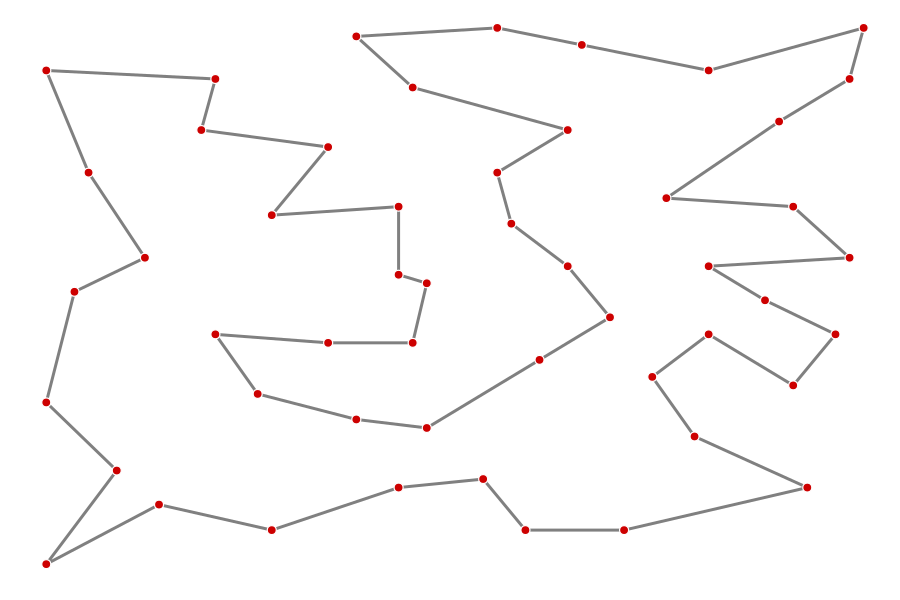

In [15]:
plot([curTour.nodes[bestPath,1];curTour.nodes[bestPath[1],1]], [curTour.nodes[bestPath,2];curTour.nodes[bestPath[1],2]], size=(900, 600), linecolor=:gray, linewidth=3, legend=false, axis=nothing, foreground_color_subplot=colorant"white")
scatter!(curTour.nodes[:,1], curTour.nodes[:,2], size=(900, 600), markercolor=:red3, markersize=5, legend=false, axis=nothing, foreground_color_subplot=colorant"white")
#savefig("Eil51.png")

20 Instances of DSWOA

In [16]:
#start = time()

bestPath, bestPathCost, mean, std = runDSWOAXTimeStats(curTour, 20)
printStatsX(curTour.name, curTour.optimal, bestPathCost, mean, std, 20)

#elapsed = time() - start

#(minutes, seconds) = fldmod(elapsed, 60)
#(hours, minutes) = fldmod(minutes, 60)

#println()
#@printf("%02d:%02d:%0.2f", hours, minutes, seconds)

Below are the performance results for the DSWOA on the TSPLIB Tour Instance eil51 after 20 executions :
Optimal Tour Cost: 426.0
DSWOA Best Tour Cost: 426.0
DSWOA Average Tour Cost: 428.55
DSWOA Standard Deviation: 2.5782746168707473
